### Denoising Autoencoder

In [12]:
import numpy as np
import torch 
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.autograd import Variable
from matplotlib import pyplot as plt

In [36]:
# Define autoencoder

class Autoencoder(nn.Module):
    
    def __init__(self):
        super(Autoencoder,self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(784,400),
            nn.ReLU(),
            nn.Linear(400,20),
            nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(20,400),
            nn.ReLU(),
            nn.Linear(400,784),
            nn.Sigmoid()
        )
        
        
    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [ ]:
# Converting images and vectors

def image_to_vector(image):
    return image.view(image.size(0), 784)

def vector_to_image(vector):
    return vector.view(vector.size(0),1,28,28)

In [ ]:
# Load data
mnist_train = datasets.MNIST("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test  = datasets.MNIST("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)
train_loader = DataLoader(dataset=mnist_train,batch_size=64,shuffle=True)
test_loader = DataLoader(dataset=mnist_test, batch_size=10, shuffle=False)

In [37]:
# Putting stuff together
n_epochs = 10
batch_size = 64
model = Autoencoder().cpu()
loss = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(),weight_decay=0.0005)

In [38]:
# Train 

losses = []

for epoch in range(n_epochs):
    
    train_loss = 0.0
    
    for data in train_loader:
        
        images,_ = data
        
        noisy_imgs = images + torch.randn(*images.shape)
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
        noisy_imgs = image_to_vector(noisy_imgs)
        images = image_to_vector(images)
        
        optimizer.zero_grad()
        
        
        outputs = model(noisy_imgs)
        
        lss = loss(outputs, images)
        lss.backward()
        
        optimizer.step()
        
        train_loss += lss.item()*images.size(0)
        
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
    epoch, 
    train_loss
    ))
    
    losses.append(train_loss)
        

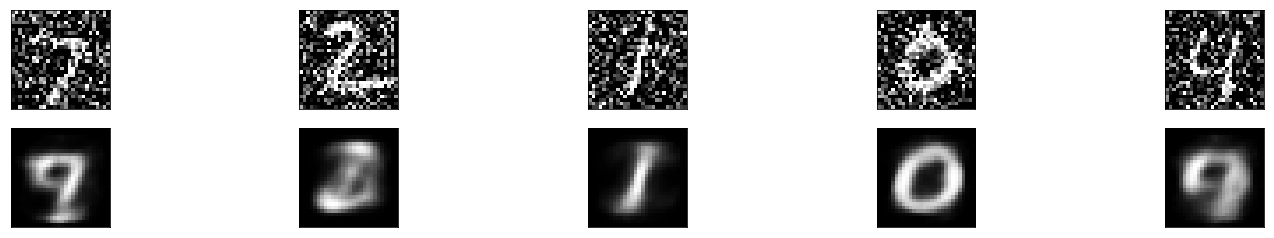

In [185]:
# Testing
# obtain one_batch of images
dataiter = iter(test_loader)
images,labels = dataiter.next()

noisy_imgs = images + 0.5*torch.randn(*images.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)
noisy_imgs = image_to_vector(noisy_imgs)

output = model(noisy_imgs)
output = output.view(10, 1, 28, 28)
output = output.detach().numpy()
noisy_imgs = vector_to_image(noisy_imgs)

fig, axes = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True, figsize=(25,4))

for noisy_imgs, row in zip([noisy_imgs, output], axes):
    for img, ax in zip(noisy_imgs, row):
        ax.imshow(img.reshape(28,28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
plt.savefig('dAE.png')

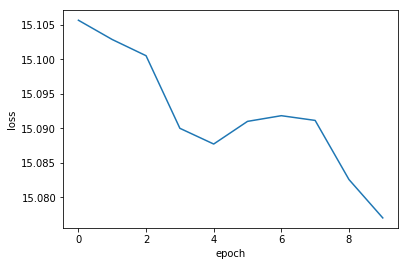

In [190]:
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig('dAEloss.png')